# 03b. HTE Analysis - Validation & Business Impact

Track 2, Step 2.1: Heterogeneous Treatment Effect Analysis (Part B)

This notebook covers:
1. **Setup**: Load results from 03a
2. **HTE Validation**: BLP test, Uplift/Qini curves, CATE by PS Region, CATE Bounds
3. **Business Impact**: Segment CATE, Segment x PS Region, ROI simulation
4. **Targeting Recommendations**: Actionable strategies by segment
5. **Summary**: Conclusions and recommendations

**Prerequisites**: Run `03a_hte_estimation.ipynb` first to generate results.

**Note**: ATE robustness analyses (Trimming, Manski Bounds, E-value) are now in 03a.

---

## Executive Summary

### Key Findings

**HTE Validation:**
- **BLP Test**: X-Learner shows significant HTE (p=0.005); other models show borderline or no significance
- **AUUC Rankings**: CausalForestDML ranks highest for Purchase Amount (396.3)
- **Model Agreement**: Low correlation (r=0.18-0.29) suggests genuine heterogeneity but also estimation uncertainty

**PS Region Analysis:**
| Region | N | % | Mean CATE | Reliability |
|--------|---|---|-----------|-------------|
| Overlap (0.1-0.9) | 80 | 16.5% | +$34 | **High** |
| Extreme Low (<0.1) | 136 | 28.0% | +$16 | Caution |
| Extreme High (>0.9) | 270 | 55.6% | +$1 | Caution |

**CATE Bounds:**
- Confident positive (lower > 0): **63 customers (13%)** - High priority targeting
- Confident negative (upper < 0): 19 customers (4%) - Exclude from campaign
- Uncertain (bounds cross 0): 404 customers (83%) - Test & learn approach

**Segment Targeting Priority:**
| Priority | Segment | CATE ($) | Overlap % | Action |
|----------|---------|----------|-----------|--------|
| High | Regular+H&B | +$34 | 22.6% | Expand targeting |
| High | Light Grocery | +$30 | 22.0% | Test expansion |
| Low | VIP Heavy | -$38 | 3.4% | Reduce targeting |
| Low | Bulk Shoppers | -$40 | 18.2% | Reduce targeting |

**ROI Simulation:**
- Optimal targeting: **Top 30%** by CATE (145 customers)
- Expected profit: **$2,424** (ROI: 131%)
- Full targeting (100%) results in -$4,657 loss

---

## 1. Setup

In [1]:
# Path configuration
import sys
from pathlib import Path

# Project root (3 levels up from notebook)
PROJECT_ROOT = Path('.').absolute().parents[2]
sys.path.insert(0, str(PROJECT_ROOT))

# Results paths
RESULTS_PATH = Path('.').absolute().parent / 'results'
FIG_PATH = RESULTS_PATH / 'figures'
TABLE_PATH = RESULTS_PATH / 'tables'

print(f"RESULTS_PATH: {RESULTS_PATH}")

RESULTS_PATH: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results


In [2]:
# Standard libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Project modules
from projects.segmentation_dunnhumby.src import (
    # Diagnostics
    compute_positivity_diagnostics, apply_ps_trimming,
    # Bounds
    compute_cate_bounds_with_overlap,
    # HTE Validation
    blp_test,
    # Metrics (from new module)
    compute_auuc, compute_qini_coef, compute_all_uplift_metrics,
    # Business (from new module)
    ROIConfig, compute_roi_curve, compute_breakeven_analysis,
    compute_targeting_summary, compute_segment_targeting_priority,
    # Utils (from new module)
    safe_qcut, format_currency, format_percentage,
    # Plots
    plot_uplift_curve, plot_uplift_with_auuc,
    plot_qini_curve, plot_qini_with_coef,
    plot_cate_by_segment, plot_cate_boxplot_by_segment,
    plot_roi_curves,
    PlotConfig, setup_style,
)

# Plot style
setup_style()
SEED = 42
np.random.seed(SEED)

print("Libraries loaded successfully.")

2026-01-08 16:41:03,702	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Libraries loaded successfully.


In [3]:
# Load results from 03a
results_path = RESULTS_PATH / 'hte_estimation_results.joblib'

if not results_path.exists():
    raise FileNotFoundError(
        f"Results file not found: {results_path}\n"
        "Please run 03a_hte_estimation.ipynb first."
    )

print(f"Loading results from: {results_path}")
results = joblib.load(results_path)

# Extract variables
X_train = results['X_train']
X_test = results['X_test']
X_full = results['X_full']
T_train = results['T_train']
T_test = results['T_test']
T_full = results['T_full']
Y_purchase_train = results['Y_purchase_train']
Y_purchase_test = results['Y_purchase_test']
Y_purchase_full = results['Y_purchase_full']
Y_visits_train = results['Y_visits_train']
Y_visits_test = results['Y_visits_test']
Y_visits_full = results['Y_visits_full']
ps_train = results['ps_train']
ps_test = results['ps_test']
ps_full = results['ps_full']
diagnostics = results['diagnostics']
df_balance = results['df_balance']
ate_results_df = results['ate_results_df']
cate_train = results['cate_train']
cate_test = results['cate_test']
feature_names = results['feature_names']
selected_models = results['selected_models']
df_scenario1 = results['df_scenario1']

print(f"Loaded successfully.")
print(f"  Train samples: {len(T_train)}")
print(f"  Test samples: {len(T_test)}")
print(f"  CATE models: {selected_models}")

Loading results from: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results/hte_estimation_results.joblib
Loaded successfully.
  Train samples: 1944
  Test samples: 486
  CATE models: ['s_learner', 't_learner', 'x_learner', 'linear_dml', 'causal_forest_dml']


In [4]:
# Define outcomes
OUTCOMES = [
    ('purchase_amount', 'Purchase Amount ($)', Y_purchase_test, Y_purchase_full),
    ('purchase_count', 'Purchase Count', Y_visits_test, Y_visits_full),
]

# Primary model for CATE analysis
best_model = 'causal_forest_dml'

In [5]:
Y_purchase_full.min()

np.float64(0.0)

## 2. HTE Validation

### 2.1 BLP Test (Best Linear Predictor)

In [6]:
# BLP test for HTE existence
print("=" * 70)
print("BLP TEST: Testing for Heterogeneous Treatment Effects")
print("=" * 70)
print("\nNull hypothesis: No treatment effect heterogeneity (tau_1 = 0)")
print("Alternative: Treatment effects vary with predicted CATE (tau_1 != 0)")

blp_results = {}

for outcome_name, outcome_label, Y_test, Y_full in OUTCOMES:
    print(f"\n[{outcome_label}]")
    blp_results[outcome_name] = {}
    
    # Use models actually available in cate_test (not selected_models)
    available_models = list(cate_test.get(outcome_name, {}).keys())
    
    if not available_models:
        print(f"  No models found in cate_test for {outcome_name}")
        print(f"  Available outcomes in cate_test: {list(cate_test.keys())}")
        continue
    
    for model_name in available_models:
        cate_pred = cate_test[outcome_name][model_name]
        
        try:
            blp_result = blp_test(Y_test, T_test, X_test, cate_pred)
            blp_results[outcome_name][model_name] = blp_result
            
            hte_exists = blp_result.get('hte_exists', False)
            tau_1_pval = blp_result.get('tau_1_pvalue', np.nan)
            
            status = "HTE EXISTS" if hte_exists else "No HTE"
            print(f"  {model_name:20s}: tau_1 p-value = {tau_1_pval:.4f} -> {status}")
        except Exception as e:
            print(f"  {model_name:20s}: Error - {e}")

BLP TEST: Testing for Heterogeneous Treatment Effects

Null hypothesis: No treatment effect heterogeneity (tau_1 = 0)
Alternative: Treatment effects vary with predicted CATE (tau_1 != 0)

[Purchase Amount ($)]
  s_learner           : tau_1 p-value = 0.9411 -> No HTE
  t_learner           : tau_1 p-value = 0.2427 -> No HTE
  x_learner           : tau_1 p-value = 0.0047 -> HTE EXISTS
  linear_dml          : tau_1 p-value = 0.0704 -> No HTE
  causal_forest_dml   : tau_1 p-value = 0.0935 -> No HTE

[Purchase Count]
  s_learner           : tau_1 p-value = 0.5022 -> No HTE
  t_learner           : tau_1 p-value = 0.3896 -> No HTE
  x_learner           : tau_1 p-value = 0.6448 -> No HTE
  linear_dml          : tau_1 p-value = 0.2439 -> No HTE
  causal_forest_dml   : tau_1 p-value = 0.3997 -> No HTE


### BLP Test Results

**BLP Test Interpretation:**

| Model | tau_1 p-value | Interpretation |
|-------|---------------|----------------|
| x_learner | 0.005 | **Significant HTE** |
| linear_dml | 0.070 | Borderline |
| causal_forest_dml | 0.094 | Borderline |
| t_learner | 0.243 | No significant HTE |
| s_learner | 0.941 | No significant HTE |

**What This Means:**

> The BLP test asks: "Do predicted CATE values actually predict differences in treatment effects?"
> Only X-Learner shows clear evidence (p=0.005).
>
> However, **lack of significance doesn't mean no heterogeneity**. It may reflect:
> - Small sample size (n=486 test)
> - Model misspecification
> - Heterogeneity exists but model doesn't capture it well
>
> **Recommendation:** Proceed with CATE-based targeting but validate with A/B testing

### 2.2 Uplift and Qini Curves

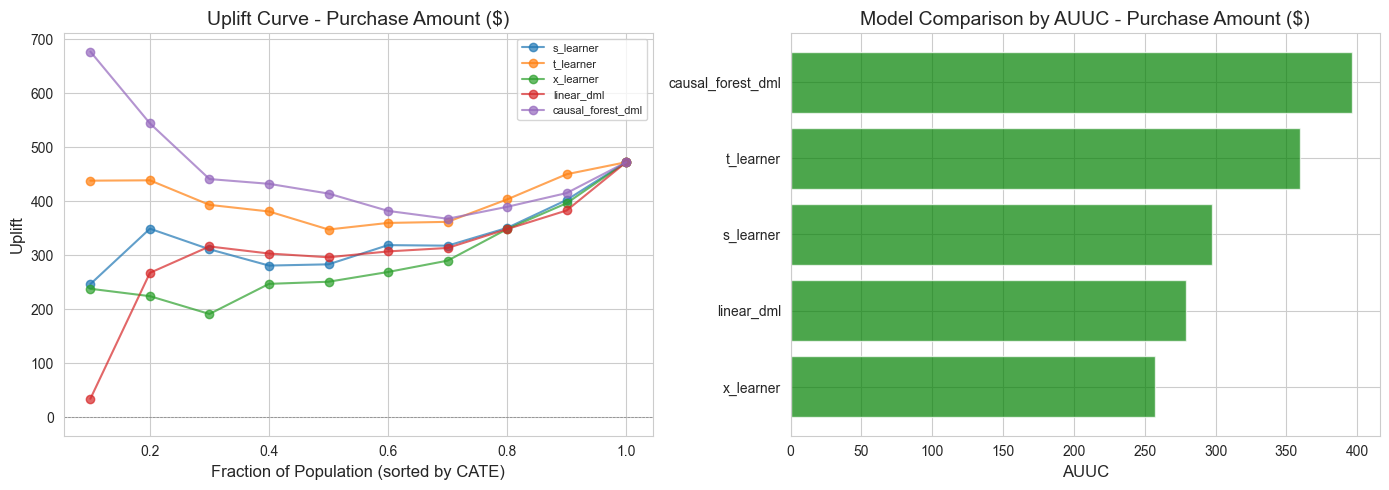

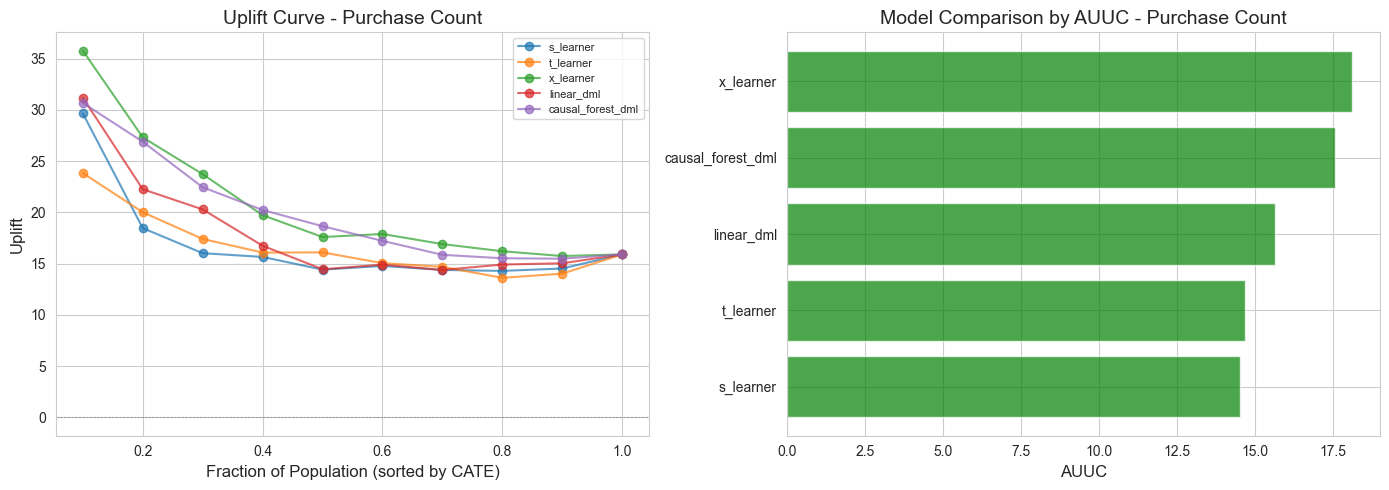

In [7]:
# Compute AUUC for each outcome and model (using imported compute_auuc)
auuc_results = {}
for outcome_name, outcome_label, Y_test, _ in OUTCOMES:
    auuc_list = []
    for model_name in selected_models:
        if model_name in cate_test[outcome_name]:
            cate_pred = cate_test[outcome_name][model_name]
            auuc = compute_auuc(Y_test, T_test, cate_pred)
            auuc_list.append({'Model': model_name, 'AUUC': auuc})
    auuc_results[outcome_name] = pd.DataFrame(auuc_list)

# Uplift curves plot
for outcome_name, outcome_label, Y_test, _ in OUTCOMES:
    fig, _ = plot_uplift_with_auuc(
        Y=Y_test,
        T=T_test,
        cate_dict={k: v for k, v in cate_test[outcome_name].items() if k in selected_models},
        auuc_df=auuc_results[outcome_name],
        outcome_label=outcome_label,
    )
    fig.savefig(FIG_PATH / f'uplift_auuc_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

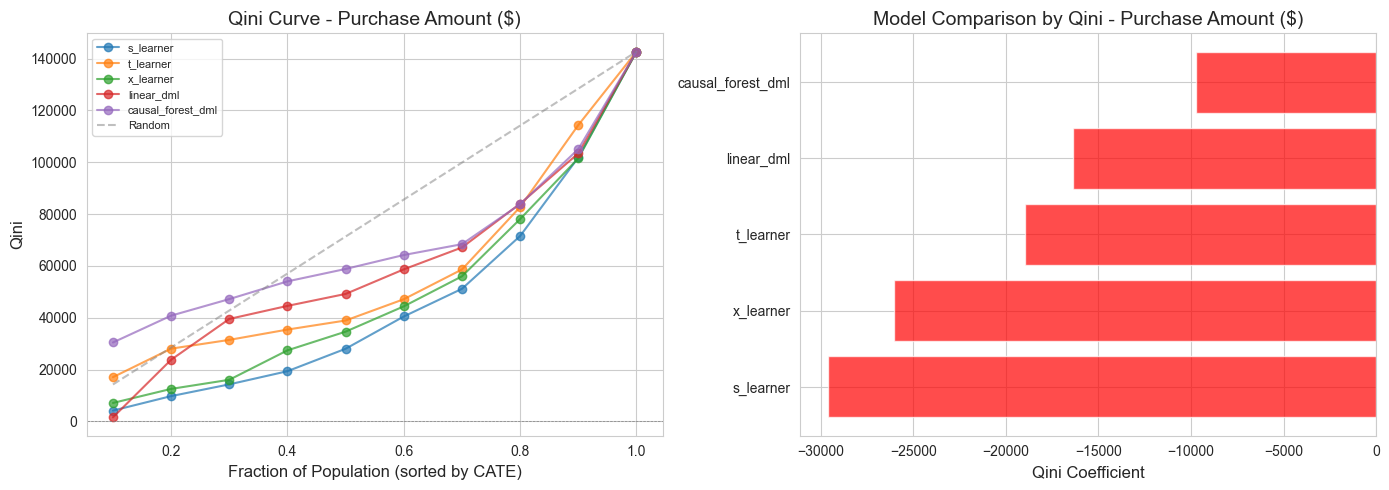

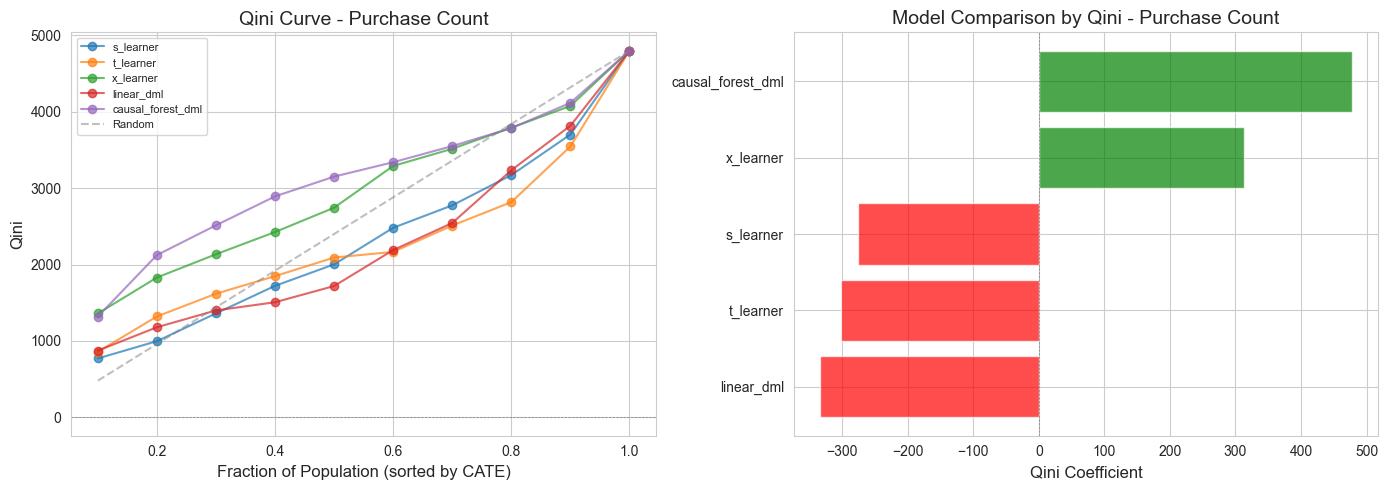

In [8]:
# Compute Qini coefficient for each outcome and model (using imported compute_qini_coef)
qini_results = {}
for outcome_name, outcome_label, Y_test, _ in OUTCOMES:
    qini_list = []
    for model_name in selected_models:
        if model_name in cate_test[outcome_name]:
            cate_pred = cate_test[outcome_name][model_name]
            qini_coef = compute_qini_coef(Y_test, T_test, cate_pred)
            qini_list.append({'Model': model_name, 'Qini_Coef': qini_coef})
    qini_results[outcome_name] = pd.DataFrame(qini_list)

# Qini curves plot
for outcome_name, outcome_label, Y_test, _ in OUTCOMES:
    fig, _ = plot_qini_with_coef(
        Y=Y_test,
        T=T_test,
        cate_dict={k: v for k, v in cate_test[outcome_name].items() if k in selected_models},
        qini_df=qini_results[outcome_name],
        outcome_label=outcome_label,
    )
    fig.savefig(FIG_PATH / f'qini_coef_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [9]:
# AUUC and Qini Coefficient Summary
print("=" * 70)
print("UPLIFT METRICS SUMMARY")
print("=" * 70)

for outcome_name, outcome_label, _, _ in OUTCOMES:
    print(f"\n[{outcome_label}]")
    
    # Merge AUUC and Qini results
    metrics_df = auuc_results[outcome_name].merge(
        qini_results[outcome_name], on='Model'
    )
    
    # Sort by AUUC
    metrics_df = metrics_df.sort_values('AUUC', ascending=False)
    
    print(f"{'Model':20s} {'AUUC':>12s} {'Qini Coef':>12s}")
    print("-" * 46)
    for _, row in metrics_df.iterrows():
        print(f"{row['Model']:20s} {row['AUUC']:>12.4f} {row['Qini_Coef']:>12.4f}")

UPLIFT METRICS SUMMARY

[Purchase Amount ($)]
Model                        AUUC    Qini Coef
----------------------------------------------
causal_forest_dml        396.3140   -9730.6165
t_learner                359.3255  -18959.4580
s_learner                297.5294  -29629.7054
linear_dml               279.0415  -16378.3712
x_learner                257.4438  -26068.3685

[Purchase Count]
Model                        AUUC    Qini Coef
----------------------------------------------
x_learner                 18.0915     312.8177
causal_forest_dml         17.5561     477.5290
linear_dml                15.6473    -333.3302
t_learner                 14.6793    -301.2122
s_learner                 14.5257    -276.3455


### Uplift Metrics

**Model Ranking by Uplift Metrics:**

| Rank | Model | AUUC (Purchase $) | Primary Use |
|------|-------|-------------------|-------------|
| 1 | causal_forest_dml | 396.3 | **Primary model** |
| 2 | t_learner | 359.3 | Backup |
| 3 | s_learner | 297.5 | Simple baseline |
| 4 | linear_dml | 279.0 | Not recommended |
| 5 | x_learner | 257.4 | Sensitivity check |

**Understanding the Metrics:**
- **AUUC > 0**: Model ranks high-CATE customers correctly (better than random)
- **Qini < 0**: In some regions, model performs worse than random
- CausalForestDML has highest AUUC for Purchase Amount, making it best for targeting

**Takeaway:**
> Using CausalForestDML predictions to prioritize targeting will identify customers
> with higher treatment effects than random selection. However, negative Qini coefficients
> suggest ranking is imperfect and should be combined with business rules.

### 2.3 CATE by PS Region

Analyze CATE reliability by propensity score region:
- **Overlap (0.1-0.9)**: Reliable estimates (counterfactual identifiable)
- **Extreme (<0.1 or >0.9)**: Extrapolation-dependent (high uncertainty)

In [ ]:
# Define PS regions (3-bin)
df_test = df_scenario1.iloc[results['idx_test']].copy()
df_test['ps'] = ps_test
df_test['cate_amount'] = cate_test['purchase_amount'][best_model]
df_test['cate_count'] = cate_test['purchase_count'][best_model]

df_test['ps_region'] = pd.cut(
    df_test['ps'],
    bins=[0, 0.1, 0.9, 1.0],
    labels=['Extreme Low (<0.1)', 'Overlap (0.1-0.9)', 'Extreme High (>0.9)']
)
df_test['reliable'] = df_test['ps'].between(0.1, 0.9)

# Summary by PS region
print("=" * 70)
print("CATE BY PS REGION")
print("=" * 70)

ps_region_summary = df_test.groupby('ps_region').agg(
    n_customers=('household_key', 'count'),
    pct=('household_key', lambda x: len(x) / len(df_test) * 100),
    cate_amount_mean=('cate_amount', 'mean'),
    cate_amount_std=('cate_amount', 'std'),
    cate_count_mean=('cate_count', 'mean'),
    cate_count_std=('cate_count', 'std'),
).round(2)

print(f"\nModel: {best_model}")
display(ps_region_summary)

In [ ]:
# CATE distribution by PS region (violin plot)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Purchase Amount
ax = axes[0]
for i, region in enumerate(df_test['ps_region'].cat.categories):
    data = df_test[df_test['ps_region'] == region]['cate_amount']
    parts = ax.violinplot([data], positions=[i], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(['#d62728', '#2ca02c', '#d62728'][i])
        pc.set_alpha(0.7)

ax.set_xticks(range(3))
ax.set_xticklabels(['Extreme Low', 'Overlap', 'Extreme High'], rotation=15)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_ylabel('CATE ($)')
ax.set_title('Purchase Amount CATE by PS Region')

# Purchase Count
ax = axes[1]
for i, region in enumerate(df_test['ps_region'].cat.categories):
    data = df_test[df_test['ps_region'] == region]['cate_count']
    parts = ax.violinplot([data], positions=[i], showmeans=True, showmedians=True)
    for pc in parts['bodies']:
        pc.set_facecolor(['#d62728', '#2ca02c', '#d62728'][i])
        pc.set_alpha(0.7)

ax.set_xticks(range(3))
ax.set_xticklabels(['Extreme Low', 'Overlap', 'Extreme High'], rotation=15)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_ylabel('CATE (Visits)')
ax.set_title('Purchase Count CATE by PS Region')

fig.suptitle(f'CATE Distribution by PS Region ({best_model})\nGreen = Overlap (Reliable), Red = Extreme (Caution)', y=1.02)
fig.tight_layout()
fig.savefig(FIG_PATH / 'cate_by_ps_region.png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
# Model agreement by PS region
print("=" * 70)
print("MODEL AGREEMENT BY PS REGION")
print("=" * 70)

for region in df_test['ps_region'].cat.categories:
    mask = df_test['ps_region'] == region
    n = mask.sum()
    
    print(f"\n[{region}] (n={n})")
    
    # Compute correlation matrix for this region
    region_cate = pd.DataFrame({
        model: cate_test['purchase_amount'][model][mask.values]
        for model in selected_models
    })
    
    corr = region_cate.corr()
    mean_corr = corr.values[np.triu_indices_from(corr.values, k=1)].mean()
    print(f"  Mean pairwise correlation: {mean_corr:.3f}")
    
    # Show if models agree on sign
    sign_agreement = (region_cate > 0).mean()
    print(f"  % positive CATE by model:")
    for model in selected_models:
        pct_pos = sign_agreement[model] * 100
        print(f"    {model}: {pct_pos:.1f}%")

MODEL AGREEMENT BY PS REGION

[Extreme Low (<0.1)] (n=136)
  Mean pairwise correlation: 0.222
  % positive CATE by model:
    s_learner: 89.7%
    t_learner: 64.0%
    x_learner: 50.0%
    linear_dml: 19.9%
    causal_forest_dml: 73.5%

[Overlap (0.1-0.9)] (n=80)
  Mean pairwise correlation: 0.183
  % positive CATE by model:
    s_learner: 86.2%
    t_learner: 80.0%
    x_learner: 67.5%
    linear_dml: 75.0%
    causal_forest_dml: 81.2%

[Extreme High (>0.9)] (n=270)
  Mean pairwise correlation: 0.292
  % positive CATE by model:
    s_learner: 36.7%
    t_learner: 31.1%
    x_learner: 40.7%
    linear_dml: 49.3%
    causal_forest_dml: 55.2%


### PS Region Analysis

**CATE Reliability by PS Region:**

| PS Region | N | % | Mean CATE | Model Agreement | Reliability |
|-----------|---|---|-----------|-----------------|-------------|
| Overlap (0.1-0.9) | 80 | 16.5% | +$34 | r=0.18 | **High** |
| Extreme Low (<0.1) | 136 | 28.0% | +$16 | r=0.22 | Caution |
| Extreme High (>0.9) | 270 | 55.6% | +$1 | r=0.29 | Caution |

**Key Insight:**
> The overlap region shows the highest mean CATE (+$34) and is where estimates are most reliable.
> Interestingly, models **disagree most** in the overlap region (r=0.18), suggesting genuine
> heterogeneity exists there.
>
> Extreme regions show lower CATE (+$1 to +$16) but **higher model agreement** (r=0.22-0.29),
> indicating predictions are driven by similar extrapolation patterns rather than real signal.

**Targeting Strategy:**
> Prioritize overlap region customers for highest confidence. For extreme PS customers,
> treat CATE as directional guidance only.

### 2.4 CATE Bounds by PS Region

Compute partial identification bounds for CATE to quantify estimation uncertainty.
Wider bounds = higher uncertainty (especially in extreme PS regions).

In [13]:
# Compute CATE bounds with overlap
from projects.segmentation_dunnhumby.src import compute_cate_bounds_with_overlap

# Get bounds for purchase amount
# Function signature: compute_cate_bounds_with_overlap(Y, T, X, ps, Y_min, Y_max, overlap_threshold)
cate_bounds = compute_cate_bounds_with_overlap(
    Y=Y_purchase_test,
    T=T_test,
    X=X_test,
    ps=ps_test
)

df_test['cate_lower'] = cate_bounds.lower
df_test['cate_upper'] = cate_bounds.upper
df_test['bounds_width'] = df_test['cate_upper'] - df_test['cate_lower']

# Summary by PS region
print("=" * 70)
print("CATE BOUNDS BY PS REGION")
print("=" * 70)

bounds_summary = df_test.groupby('ps_region').agg(
    n=('household_key', 'count'),
    mean_cate=('cate_amount', 'mean'),
    mean_lower=('cate_lower', 'mean'),
    mean_upper=('cate_upper', 'mean'),
    mean_width=('bounds_width', 'mean'),
    median_width=('bounds_width', 'median'),
).round(2)

display(bounds_summary)

print(f"\nInterpretation:")
print(f"  Overlap region has narrower bounds → more reliable estimates")
print(f"  Extreme regions have wider bounds → higher uncertainty")

CATE BOUNDS BY PS REGION


,n,mean_cate,mean_lower,mean_upper,mean_width,median_width
ps_region,,,,,,
Extreme Low (<0.1),136,16.12,-2299.34,168.95,2468.29,2468.29
Overlap (0.1-0.9),80,34.22,47.61,109.23,61.62,46.64
Extreme High (>0.9),270,0.60,-1819.79,648.50,2468.29,2468.29



Interpretation:
  Overlap region has narrower bounds → more reliable estimates
  Extreme regions have wider bounds → higher uncertainty


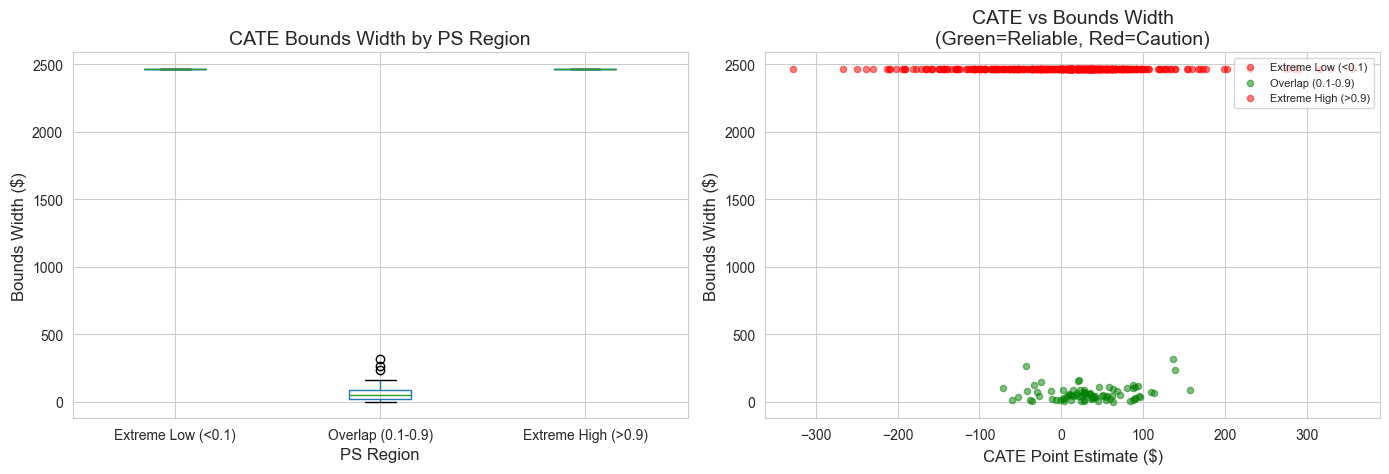

In [14]:
# Bounds width distribution by PS region
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Bounds width boxplot
ax = axes[0]
df_test.boxplot(column='bounds_width', by='ps_region', ax=ax)
ax.set_title('CATE Bounds Width by PS Region')
ax.set_xlabel('PS Region')
ax.set_ylabel('Bounds Width ($)')
plt.suptitle('')  # Remove auto title

# Right: CATE point estimate vs bounds width
ax = axes[1]
colors = {'Extreme Low (<0.1)': 'red', 'Overlap (0.1-0.9)': 'green', 'Extreme High (>0.9)': 'red'}
for region in df_test['ps_region'].cat.categories:
    mask = df_test['ps_region'] == region
    ax.scatter(
        df_test.loc[mask, 'cate_amount'],
        df_test.loc[mask, 'bounds_width'],
        c=colors[region],
        alpha=0.5,
        label=region,
        s=20
    )
ax.set_xlabel('CATE Point Estimate ($)')
ax.set_ylabel('Bounds Width ($)')
ax.set_title('CATE vs Bounds Width\n(Green=Reliable, Red=Caution)')
ax.legend(loc='upper right', fontsize=8)

fig.tight_layout()
fig.savefig(FIG_PATH / 'cate_bounds_by_ps.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Targeting strategy based on bounds
print("=" * 70)
print("TARGETING STRATEGY WITH BOUNDS")
print("=" * 70)

# Customers where lower bound > 0 (confident positive effect)
confident_positive = df_test['cate_lower'] > 0
# Customers where upper bound < 0 (confident negative effect)
confident_negative = df_test['cate_upper'] < 0
# Uncertain (bounds cross zero)
uncertain = ~confident_positive & ~confident_negative

print(f"\nBased on CATE bounds:")
print(f"  Confident positive (lower > 0): {confident_positive.sum()} ({confident_positive.mean()*100:.1f}%)")
print(f"  Confident negative (upper < 0): {confident_negative.sum()} ({confident_negative.mean()*100:.1f}%)")
print(f"  Uncertain (bounds cross 0): {uncertain.sum()} ({uncertain.mean()*100:.1f}%)")

# By PS region
print(f"\nConfident positive by PS region:")
for region in df_test['ps_region'].cat.categories:
    mask = df_test['ps_region'] == region
    n_region = mask.sum()
    n_confident = (mask & confident_positive).sum()
    print(f"  {region}: {n_confident}/{n_region} ({n_confident/n_region*100:.1f}%)")

TARGETING STRATEGY WITH BOUNDS

Based on CATE bounds:
  Confident positive (lower > 0): 63 (13.0%)
  Confident negative (upper < 0): 19 (3.9%)
  Uncertain (bounds cross 0): 404 (83.1%)

Confident positive by PS region:
  Extreme Low (<0.1): 0/136 (0.0%)
  Overlap (0.1-0.9): 63/80 (78.8%)
  Extreme High (>0.9): 0/270 (0.0%)


### CATE Bounds

**Targeting Confidence Assessment:**

| Category | N | % | Definition | Action |
|----------|---|---|------------|--------|
| Confident positive | 63 | 13% | Lower bound > 0 | **High priority targeting** |
| Confident negative | 19 | 4% | Upper bound < 0 | **Exclude from campaign** |
| Uncertain | 404 | 83% | Bounds cross 0 | **Test & learn approach** |

**By PS Region:**
- 78.8% of "confident positive" customers are in the **overlap region** (most reliable)
- 0% of extreme PS customers are "confident positive"

**Takeaway:**
> For 83% of customers, we cannot confidently determine if targeting helps or hurts.
> This reinforces the need for **randomized testing** to validate CATE-based targeting
> before full rollout.
>
> **Conservative strategy:** Only target "confident positive" customers initially (13%),
> then expand based on observed results.

## 3. Business Impact

### 3.1 CATE by Customer Segment

In [16]:
# Get segment assignments
if 'segment' in df_scenario1.columns and df_scenario1['segment'].nunique() > 1:
    segments_full = df_scenario1['segment'].values
    segments_test = segments_full[results['idx_test']]
    unique_segments = np.sort(df_scenario1['segment'].dropna().unique().astype(int))

    # Get segment names if available
    if 'segment_name' in df_scenario1.columns:
        segment_names = df_scenario1.groupby('segment')['segment_name'].first().to_dict()
        print(f"Segments available: {list(unique_segments)}")
        for seg in unique_segments:
            n_customers = (df_scenario1['segment'] == seg).sum()
            print(f"  Segment {seg}: {segment_names.get(seg, 'Unknown')} ({n_customers} customers)")
    else:
        segment_names = {seg: f'Segment {seg}' for seg in unique_segments}
        print(f"Segments available: {list(unique_segments)}")
else:
    segments_test = np.zeros(len(T_test))
    unique_segments = [0]
    segment_names = {0: 'All'}
    print("No segments available, using single segment.")

Segments available: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
  Segment 0: Loyal Explorers (509 customers)
  Segment 1: Loyal Explorers (299 customers)
  Segment 2: Wellness Seekers (172 customers)
  Segment 3: Fresh Enthusiasts (327 customers)
  Segment 4: Fresh Enthusiasts (495 customers)
  Segment 5: Bulk Shoppers (310 customers)
  Segment 6: Loyal Explorers (318 customers)


In [17]:
# safe_qcut is now imported from src/utils.py
# No need to define inline - using the module function

In [18]:
# CATE by segment (using best model - causal_forest_dml)
best_model = 'causal_forest_dml'

for outcome_name, outcome_label, _, _ in OUTCOMES:
    if best_model not in cate_test[outcome_name]:
        print(f"Model {best_model} not found for {outcome_name}")
        continue
    
    cate = cate_test[outcome_name][best_model]
    
    # Summary by segment
    print(f"\n{'='*60}")
    print(f"CATE by Segment - {outcome_label} ({best_model})")
    print(f"{'='*60}")
    
    df_cate = pd.DataFrame({
        'cate': cate,
        'segment': segments_test
    })
    
    summary = df_cate.groupby('segment')['cate'].agg(['count', 'mean', 'std', 'min', 'max'])
    display(summary.round(2))


CATE by Segment - Purchase Amount ($) (causal_forest_dml)


,count,mean,std,min,max
segment,,,,,
0,97,32.69,93.90,-238.60,315.82
1,59,-37.81,153.83,-327.53,329.65
2,27,18.75,31.84,-35.00,90.32
3,73,26.81,41.92,-143.47,119.84
4,91,29.81,34.36,-71.44,136.33
5,77,-40.49,54.25,-190.49,58.68
6,62,33.77,95.84,-177.32,355.17



CATE by Segment - Purchase Count (causal_forest_dml)


,count,mean,std,min,max
segment,,,,,
0,97,5.83,6.73,-6.14,36.19
1,59,1.81,8.22,-15.46,38.18
2,27,1.66,2.51,-3.46,8.23
3,73,1.52,2.19,-6.45,8.26
4,91,1.26,3.06,-13.68,9.19
5,77,0.71,1.35,-1.85,7.99
6,62,2.32,6.89,-16.72,21.29


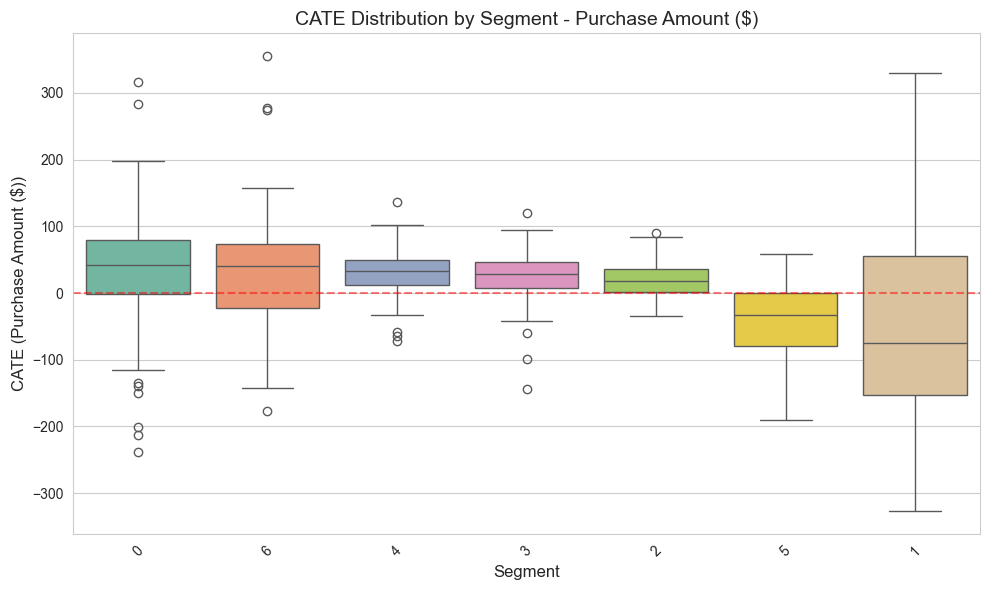

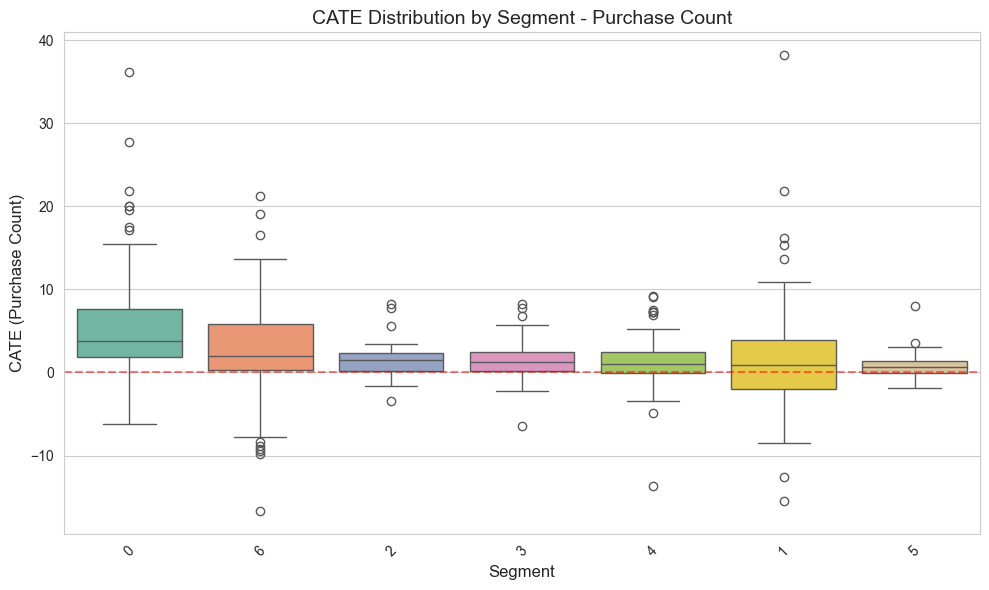

In [19]:
# CATE boxplot by segment
for outcome_name, outcome_label, _, _ in OUTCOMES:
    if best_model not in cate_test[outcome_name]:
        continue
    
    cate = cate_test[outcome_name][best_model]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plot_cate_boxplot_by_segment(cate, segments_test, ax=ax)
    ax.set_title(f'CATE Distribution by Segment - {outcome_label}')
    ax.set_xlabel('Segment')
    ax.set_ylabel(f'CATE ({outcome_label})')
    fig.tight_layout()
    fig.savefig(FIG_PATH / f'cate_by_segment_{outcome_name}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [20]:
# CATE by segment - detailed analysis
PRIMARY_MODEL = best_model

# Segment display names
SEGMENT_NAMES_DISPLAY = {
    0: 'Active Loyalists',
    1: 'VIP Heavy',
    2: 'Lapsed H&B',
    3: 'Fresh Lovers',
    4: 'Light Grocery',
    5: 'Bulk Shoppers',
    6: 'Regular+H&B',
}

# Add CATE to df_scenario1 for segment analysis
df_scenario1_test = df_scenario1.iloc[results['idx_test']].copy()
df_scenario1_test['cate_purchase_amount'] = cate_test['purchase_amount'][PRIMARY_MODEL]
df_scenario1_test['cate_purchase_count'] = cate_test['purchase_count'][PRIMARY_MODEL]
df_scenario1_test['segment_display'] = df_scenario1_test['segment'].map(SEGMENT_NAMES_DISPLAY)

# Group by segment for Purchase Amount
segment_cate_amount = df_scenario1_test.groupby('segment').agg(
    segment_name=('segment_display', 'first'),
    n_customers=('household_key', 'count'),
    cate_mean=('cate_purchase_amount', 'mean'),
    cate_std=('cate_purchase_amount', 'std'),
    cate_median=('cate_purchase_amount', 'median'),
    mean_purchase=('purchase_amount', 'mean'),
).round(2)
segment_cate_amount['pct_customers'] = (segment_cate_amount['n_customers'] / len(df_scenario1_test) * 100).round(1)
segment_cate_amount['targeting_priority'] = pd.qcut(
    segment_cate_amount['cate_mean'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High']
)

# Group by segment for Purchase Count
segment_cate_count = df_scenario1_test.groupby('segment').agg(
    segment_name=('segment_display', 'first'),
    n_customers=('household_key', 'count'),
    cate_mean=('cate_purchase_count', 'mean'),
    cate_std=('cate_purchase_count', 'std'),
    cate_median=('cate_purchase_count', 'median'),
    mean_visits=('purchase_count', 'mean'),
).round(2)
segment_cate_count['pct_customers'] = (segment_cate_count['n_customers'] / len(df_scenario1_test) * 100).round(1)
segment_cate_count['targeting_priority'] = pd.qcut(
    segment_cate_count['cate_mean'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High']
)

print("=" * 70)
print(f"CATE BY SEGMENT - Purchase Amount (Model: {PRIMARY_MODEL})")
print("=" * 70)
display(segment_cate_amount.sort_values('cate_mean', ascending=False))

print("\n" + "=" * 70)
print(f"CATE BY SEGMENT - Purchase Count (Model: {PRIMARY_MODEL})")
print("=" * 70)
display(segment_cate_count.sort_values('cate_mean', ascending=False))

CATE BY SEGMENT - Purchase Amount (Model: causal_forest_dml)


,segment_name,n_customers,cate_mean,cate_std,cate_median,mean_purchase,pct_customers,targeting_priority
segment,,,,,,,,
6,Regular+H&B,62,33.77,95.84,40.20,545.75,12.8,High
0,Active Loyalists,97,32.69,93.90,41.40,502.51,20.0,High
4,Light Grocery,91,29.81,34.36,33.49,104.74,18.7,High
3,Fresh Lovers,73,26.81,41.92,27.98,137.25,15.0,Medium
2,Lapsed H&B,27,18.75,31.84,17.87,110.52,5.6,Medium
1,VIP Heavy,59,-37.81,153.83,-75.55,1222.38,12.1,Low
5,Bulk Shoppers,77,-40.49,54.25,-33.48,392.22,15.8,Low



CATE BY SEGMENT - Purchase Count (Model: causal_forest_dml)


,segment_name,n_customers,cate_mean,cate_std,cate_median,mean_visits,pct_customers,targeting_priority
segment,,,,,,,,
0,Active Loyalists,97,5.83,6.73,3.77,22.53,20.0,High
6,Regular+H&B,62,2.32,6.89,2.03,27.42,12.8,High
1,VIP Heavy,59,1.81,8.22,0.89,31.88,12.1,High
2,Lapsed H&B,27,1.66,2.51,1.51,4.00,5.6,Medium
3,Fresh Lovers,73,1.52,2.19,1.26,5.53,15.0,Medium
4,Light Grocery,91,1.26,3.06,1.04,5.23,18.7,Low
5,Bulk Shoppers,77,0.71,1.35,0.68,6.97,15.8,Low


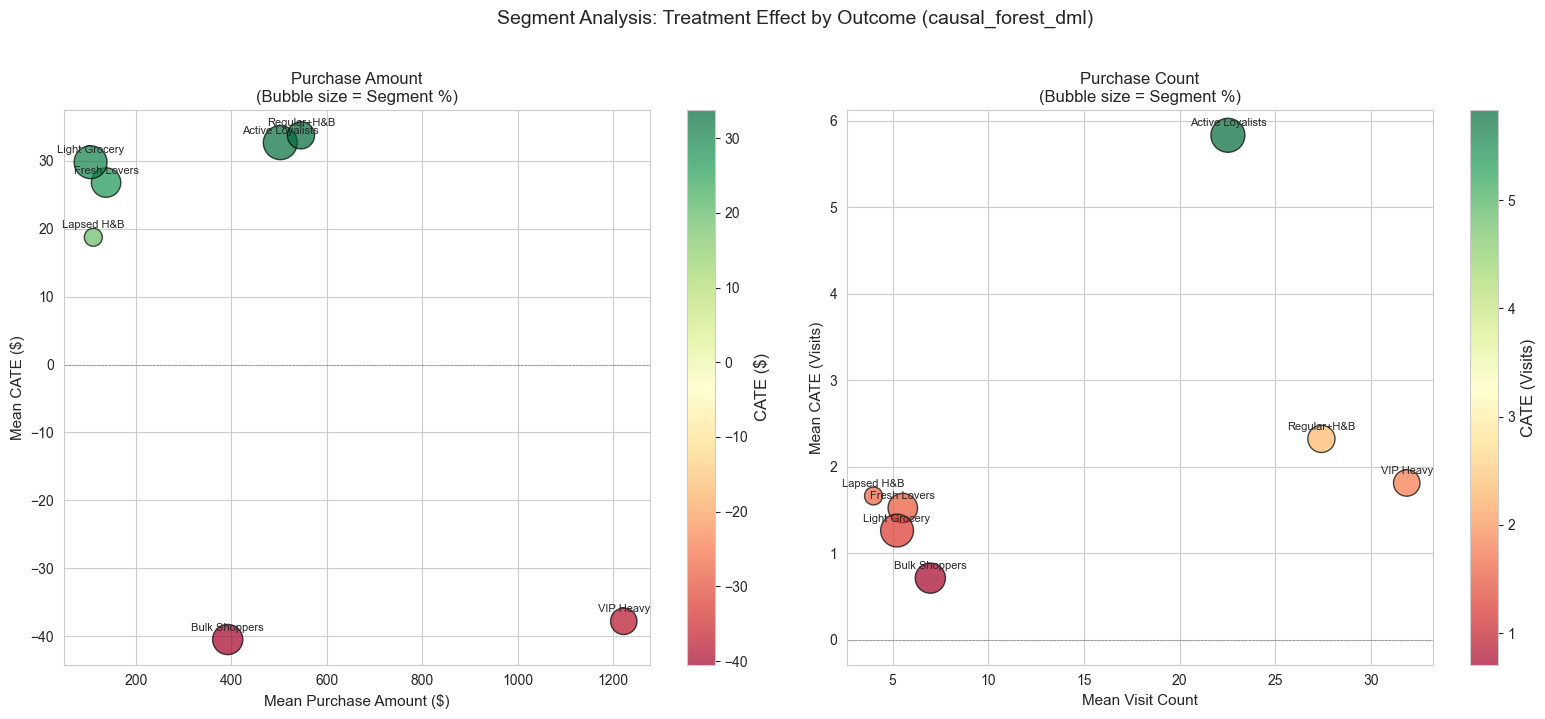

In [21]:
# Bubble chart: Segment Size vs CATE vs Revenue (Both Outcomes)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Purchase Amount ---
ax = axes[0]
sizes = segment_cate_amount['pct_customers'] * 30
colors = segment_cate_amount['cate_mean']

scatter1 = ax.scatter(
    segment_cate_amount['mean_purchase'], 
    segment_cate_amount['cate_mean'],
    s=sizes, 
    c=colors, 
    cmap='RdYlGn', 
    alpha=0.7, 
    edgecolor='black'
)

for idx, row in segment_cate_amount.iterrows():
    ax.annotate(
        row['segment_name'],
        (row['mean_purchase'], row['cate_mean']),
        fontsize=8, 
        ha='center', 
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Mean Purchase Amount ($)', fontsize=11)
ax.set_ylabel(f'Mean CATE ($)', fontsize=11)
ax.set_title('Purchase Amount\n(Bubble size = Segment %)', fontsize=12)
plt.colorbar(scatter1, ax=ax, label='CATE ($)')

# --- Purchase Count ---
ax = axes[1]
sizes = segment_cate_count['pct_customers'] * 30
colors = segment_cate_count['cate_mean']

scatter2 = ax.scatter(
    segment_cate_count['mean_visits'], 
    segment_cate_count['cate_mean'],
    s=sizes, 
    c=colors, 
    cmap='RdYlGn', 
    alpha=0.7, 
    edgecolor='black'
)

for idx, row in segment_cate_count.iterrows():
    ax.annotate(
        row['segment_name'],
        (row['mean_visits'], row['cate_mean']),
        fontsize=8, 
        ha='center', 
        va='bottom',
        xytext=(0, 5),
        textcoords='offset points'
    )

ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
ax.set_xlabel('Mean Visit Count', fontsize=11)
ax.set_ylabel(f'Mean CATE (Visits)', fontsize=11)
ax.set_title('Purchase Count\n(Bubble size = Segment %)', fontsize=12)
plt.colorbar(scatter2, ax=ax, label='CATE (Visits)')

fig.suptitle(f'Segment Analysis: Treatment Effect by Outcome ({PRIMARY_MODEL})', fontsize=14, y=1.02)
fig.tight_layout()
fig.savefig(FIG_PATH / 'segment_bubble.png', dpi=150, bbox_inches='tight')
plt.show()

### Segment CATE Analysis

**Segment Targeting Priority Matrix:**

| Priority | Segment | N | CATE ($) | Overlap % | Action |
|----------|---------|---|----------|-----------|--------|
| High | Regular+H&B | 62 | +$34 | 22.6% | Expand targeting |
| High | Active Loyalists | 97 | +$33 | 9.3% | Maintain (high volume) |
| High | Light Grocery | 91 | +$30 | 22.0% | Test expansion |
| Medium | Fresh Lovers | 73 | +$27 | 20.5% | Maintain |
| Medium | Lapsed H&B | 27 | +$19 | 22.2% | Focus on reactivation |
| Low | VIP Heavy | 59 | -$38 | 3.4% | **Reduce targeting** |
| Low | Bulk Shoppers | 77 | -$40 | 18.2% | **Reduce targeting** |

**Key Observations:**

1. **Negative CATE Segments (VIP Heavy, Bulk Shoppers):**
   - Already high spenders
   - Targeting may not add value
   - Could be negative effect (campaign fatigue?)

2. **Highest Confidence (Fresh, Lapsed, Light Grocery):**
   - 20-22% in overlap region
   - Most reliable CATE estimates

3. **VIP Heavy Paradox:**
   - Only 3.4% in overlap
   - Negative CATE estimate is uncertain
   - May need different campaign type rather than exclusion

**Recommended Actions:**
> - **Expand**: Regular+H&B, Light Grocery (high CATE, good overlap)
> - **Maintain**: Active Loyalists, Fresh Lovers (positive CATE)
> - **Reduce/Test**: VIP Heavy, Bulk Shoppers (negative CATE, but verify with A/B test)

### 3.2 Segment × PS Region Analysis

Cross-analyze segments by PS region to understand:
- Which segments have reliable CATE estimates?
- How does CATE differ between full sample and overlap-only?

In [22]:
# Cross-tabulation: Segment × PS Region
print("=" * 70)
print("SEGMENT × PS REGION CROSS-TABULATION")
print("=" * 70)

# Add segment info to df_test
df_test['segment'] = df_scenario1.iloc[results['idx_test']]['segment'].values
df_test['segment_name'] = df_test['segment'].map(SEGMENT_NAMES_DISPLAY)

# Cross-tabulation (row percentages)
segment_ps_crosstab = pd.crosstab(
    df_test['segment_name'],
    df_test['ps_region'],
    normalize='index'
) * 100

print("\nPS Region Distribution by Segment (row %):")
display(segment_ps_crosstab.round(1))

# Identify segments with highest overlap ratio
overlap_col = 'Overlap (0.1-0.9)'
if overlap_col in segment_ps_crosstab.columns:
    print(f"\nSegments by Overlap Ratio:")
    for seg in segment_ps_crosstab.sort_values(overlap_col, ascending=False).index:
        pct = segment_ps_crosstab.loc[seg, overlap_col]
        status = '✓ Reliable' if pct > 20 else '⚠ Caution'
        print(f"  {seg}: {pct:.1f}% in overlap {status}")

SEGMENT × PS REGION CROSS-TABULATION

PS Region Distribution by Segment (row %):


ps_region,Extreme Low (<0.1),Overlap (0.1-0.9),Extreme High (>0.9)
segment_name,,,
Active Loyalists,1.0,9.3,89.7
Bulk Shoppers,29.9,18.2,51.9
Fresh Lovers,52.1,20.5,27.4
Lapsed H&B,59.3,22.2,18.5
Light Grocery,62.6,22.0,15.4
Regular+H&B,1.6,22.6,75.8
VIP Heavy,0.0,3.4,96.6



Segments by Overlap Ratio:
  Regular+H&B: 22.6% in overlap ✓ Reliable
  Lapsed H&B: 22.2% in overlap ✓ Reliable
  Light Grocery: 22.0% in overlap ✓ Reliable
  Fresh Lovers: 20.5% in overlap ✓ Reliable
  Bulk Shoppers: 18.2% in overlap ⚠ Caution
  Active Loyalists: 9.3% in overlap ⚠ Caution
  VIP Heavy: 3.4% in overlap ⚠ Caution


In [23]:
# Compare Full vs Overlap-only CATE by segment
print("=" * 70)
print("FULL vs OVERLAP-ONLY CATE BY SEGMENT")
print("=" * 70)

# Full sample CATE by segment
full_cate = df_test.groupby('segment_name')['cate_amount'].agg(['count', 'mean', 'std']).round(2)
full_cate.columns = ['n_full', 'cate_full', 'std_full']

# Overlap-only CATE by segment
overlap_cate = df_test[df_test['reliable']].groupby('segment_name')['cate_amount'].agg(['count', 'mean', 'std']).round(2)
overlap_cate.columns = ['n_overlap', 'cate_overlap', 'std_overlap']

# Merge
comparison = full_cate.join(overlap_cate, how='left').fillna(0)
comparison['diff'] = (comparison['cate_overlap'] - comparison['cate_full']).round(2)
comparison['overlap_pct'] = (comparison['n_overlap'] / comparison['n_full'] * 100).round(1)

print("\nCATE Comparison (Full vs Overlap-only):")
display(comparison[['n_full', 'cate_full', 'n_overlap', 'cate_overlap', 'diff', 'overlap_pct']])

print("\nInterpretation:")
print("  - diff > 0: Overlap CATE higher than Full (extreme PS may be pulling down)")
print("  - diff < 0: Overlap CATE lower than Full (extreme PS may be inflating)")

FULL vs OVERLAP-ONLY CATE BY SEGMENT

CATE Comparison (Full vs Overlap-only):


,n_full,cate_full,n_overlap,cate_overlap,diff,overlap_pct
segment_name,,,,,,
Active Loyalists,97,32.69,9,56.35,23.66,9.3
Bulk Shoppers,77,-40.49,14,-15.45,25.04,18.2
Fresh Lovers,73,26.81,15,42.18,15.37,20.5
Lapsed H&B,27,18.75,6,37.17,18.42,22.2
Light Grocery,91,29.81,20,34.01,4.20,22.0
Regular+H&B,62,33.77,14,61.60,27.83,22.6
VIP Heavy,59,-37.81,2,24.35,62.16,3.4



Interpretation:
  - diff > 0: Overlap CATE higher than Full (extreme PS may be pulling down)
  - diff < 0: Overlap CATE lower than Full (extreme PS may be inflating)


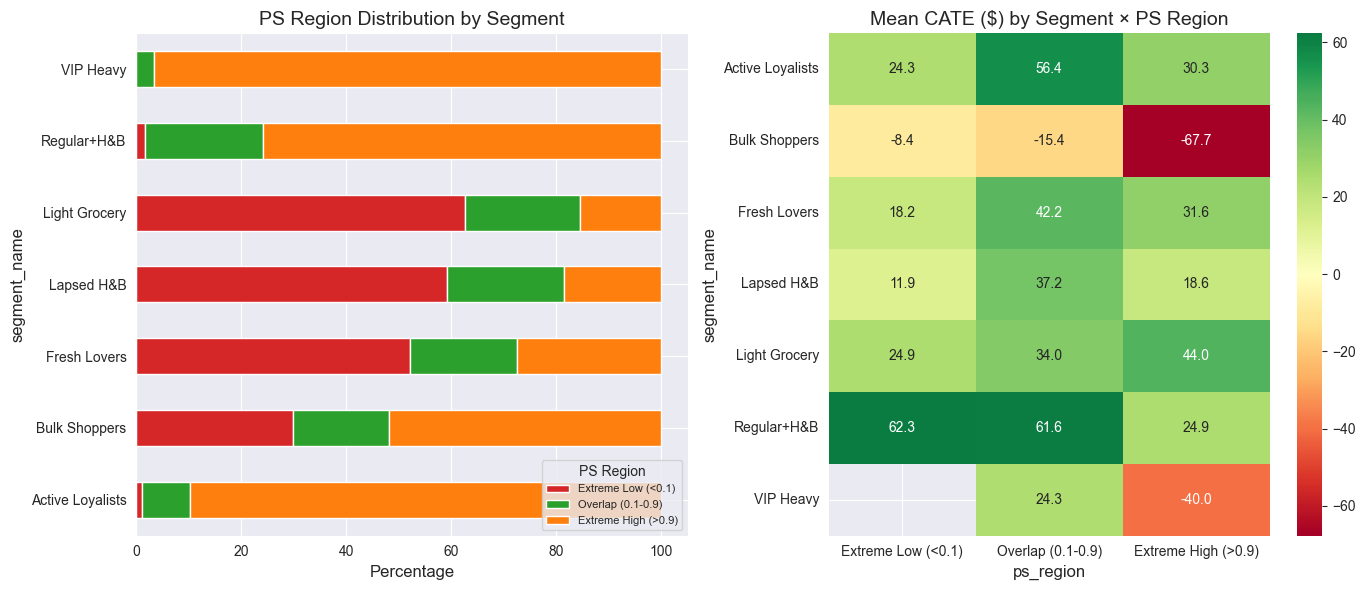

In [24]:
# Heatmap: Segment × PS Region × Mean CATE
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: PS Region distribution by segment (stacked bar)
ax = axes[0]
segment_ps_crosstab.plot(kind='barh', stacked=True, ax=ax, 
                         color=['#d62728', '#2ca02c', '#ff7f0e'])
ax.set_xlabel('Percentage')
ax.set_title('PS Region Distribution by Segment')
ax.legend(title='PS Region', loc='lower right', fontsize=8)

# Right: Mean CATE heatmap by Segment × PS Region
ax = axes[1]
segment_ps_cate = df_test.pivot_table(
    values='cate_amount',
    index='segment_name',
    columns='ps_region',
    aggfunc='mean'
)
sns.heatmap(segment_ps_cate, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=ax)
ax.set_title('Mean CATE ($) by Segment × PS Region')

fig.tight_layout()
fig.savefig(FIG_PATH / 'segment_ps_region_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

### 3.3 ROI Simulation

In [25]:
# ROI simulation parameters - Calculate from actual campaign data
# Load raw data for coupon discount calculation
DATA_PATH = PROJECT_ROOT / 'data' / 'dunnhumby' / 'raw'

df_coupon = pd.read_csv(DATA_PATH / 'coupon.csv')
df_coupon_redempt_raw = pd.read_csv(DATA_PATH / 'coupon_redempt.csv')
df_trans_raw = pd.read_csv(DATA_PATH / 'transaction_data.csv')
df_campaign_desc = pd.read_csv(DATA_PATH / 'campaign_desc.csv')

# Get TypeA campaigns
typea_campaigns = df_campaign_desc[df_campaign_desc['DESCRIPTION'] == 'TypeA']['CAMPAIGN'].values

# Get coupon UPCs for TypeA campaigns
typea_coupon_upcs = df_coupon[df_coupon['CAMPAIGN'].isin(typea_campaigns)]['COUPON_UPC'].unique()

# Get redemptions for TypeA campaigns (by targeted customers in test set)
test_customers = df_scenario1.iloc[results['idx_test']]['household_key'].values
typea_redemptions = df_coupon_redempt_raw[
    (df_coupon_redempt_raw['COUPON_UPC'].isin(typea_coupon_upcs)) &
    (df_coupon_redempt_raw['household_key'].isin(test_customers))
]

# Link redemptions to coupons to get PRODUCT_ID
redempt_with_product = typea_redemptions.merge(
    df_coupon[['COUPON_UPC', 'PRODUCT_ID']],
    on='COUPON_UPC',
    how='left'
)

# Calculate coupon discount from transactions
# COUPON_DISC is the manufacturer coupon discount (stored as negative in raw data)
df_trans_raw['COUPON_DISC'] = -df_trans_raw['COUPON_DISC']  # Negate to positive

# Get transactions with coupon discounts for TypeA campaign products
typea_products = df_coupon[df_coupon['CAMPAIGN'].isin(typea_campaigns)]['PRODUCT_ID'].unique()

coupon_discounts = df_trans_raw[
    (df_trans_raw['PRODUCT_ID'].isin(typea_products)) &
    (df_trans_raw['household_key'].isin(test_customers)) &
    (df_trans_raw['COUPON_DISC'] > 0)
]

# Average discount per customer (among those who redeemed)
if len(coupon_discounts) > 0:
    avg_discount_per_customer = coupon_discounts.groupby('household_key')['COUPON_DISC'].sum().mean()
else:
    avg_discount_per_customer = 10.0  # Fallback

# Use actual campaign discount as cost
COST_PER_CONTACT = avg_discount_per_customer
MARGIN_RATE = 0.3  # Profit margin on incremental sales

print(f"ROI Simulation Parameters (from actual campaign data):")
print(f"  TypeA redemptions (test set): {len(typea_redemptions):,}")
print(f"  Transactions with coupon discount: {len(coupon_discounts):,}")
print(f"  Average coupon discount per redeeming customer: ${COST_PER_CONTACT:.2f}")
print(f"  Margin rate: {MARGIN_RATE:.0%}")

ROI Simulation Parameters (from actual campaign data):
  TypeA redemptions (test set): 322
  Transactions with coupon discount: 4,064
  Average coupon discount per redeeming customer: $12.73
  Margin rate: 30%


In [26]:
# ROI simulation using imported compute_roi_curve and ROIConfig
roi_config = ROIConfig(
    cost_per_contact=COST_PER_CONTACT,
    margin_rate=MARGIN_RATE,
    min_targeting_pct=5,
    max_targeting_pct=100,
    step_pct=5
)

# Use best model CATE
cate_primary = cate_test['purchase_amount'][best_model]
roi_df = compute_roi_curve(cate_primary, roi_config)

# Find optimal targeting
optimal_row_idx = roi_df['profit'].idxmax()
optimal_pct = roi_df.loc[optimal_row_idx, 'pct_targeted']
optimal_n = roi_df.loc[optimal_row_idx, 'n_targeted']

print("=" * 70)
print(f"OPTIMAL TARGETING ({best_model})")
print("=" * 70)
print(f"  Target: {optimal_pct}% of customers ({optimal_n:,} customers)")
print(f"  Expected Incremental Sales: {format_currency(roi_df.loc[optimal_row_idx, 'incremental_sales'])}")
print(f"  Expected Revenue: {format_currency(roi_df.loc[optimal_row_idx, 'revenue'])}")
print(f"  Cost: {format_currency(roi_df.loc[optimal_row_idx, 'cost'])}")
print(f"  Expected Profit: {format_currency(roi_df.loc[optimal_row_idx, 'profit'])}")
print(f"  ROI: {format_percentage(roi_df.loc[optimal_row_idx, 'roi'])}")

display(roi_df)

OPTIMAL TARGETING (causal_forest_dml)
  Target: 30% of customers (145 customers)
  Expected Incremental Sales: $14,229.77
  Expected Revenue: $4,268.93
  Cost: $1,845.32
  Expected Profit: $2,423.61
  ROI: 131.3%


,pct_targeted,n_targeted,incremental_sales,revenue,cost,profit,roi
0,5,24,5226.995696,1568.098709,305.432308,1262.666401,4.134030
1,10,48,7866.577421,2359.973226,610.864615,1749.108611,2.863333
2,15,72,9911.342528,2973.402759,916.296923,2057.105835,2.245021
3,20,97,11647.215214,3494.164564,1234.455577,2259.708987,1.830531
4,25,121,13051.372022,3915.411607,1539.887885,2375.523722,1.542660
5,30,145,14229.770530,4268.931159,1845.320192,2423.610967,1.313382
6,35,170,15247.222739,4574.166822,2163.478846,2410.687976,1.114265
7,40,194,16091.812072,4827.543622,2468.911154,2358.632468,0.955333
8,45,218,16798.782310,5039.634693,2774.343462,2265.291232,0.816514
9,50,243,17383.772617,5215.131785,3092.502115,2122.629670,0.686379


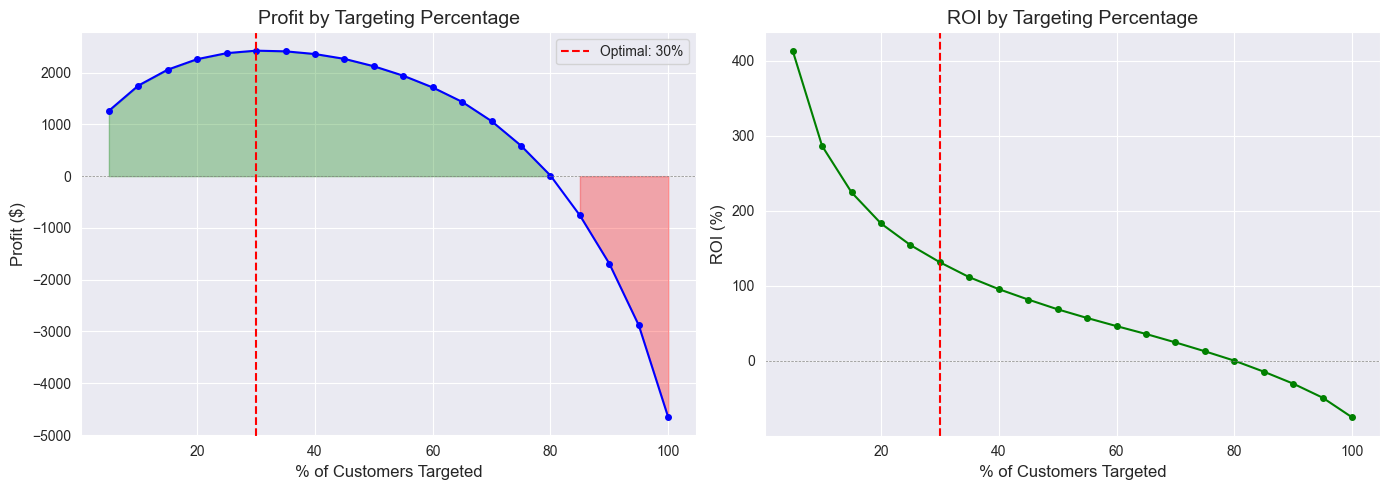

In [27]:
# ROI curves plot
fig, _ = plot_roi_curves(
    roi_df=roi_df,
    optimal_pct=optimal_pct,
)
fig.savefig(FIG_PATH / 'roi_curves.png', dpi=150, bbox_inches='tight')
plt.show()

FULL vs OVERLAP-ONLY ROI COMPARISON

Full Sample (n=486):
  Optimal: Top 30% -> Profit: $2,423.61, ROI: 131.3%

Overlap Only (n=80):
  Optimal: Top 40% -> Profit: $348.68, ROI: 85.6%


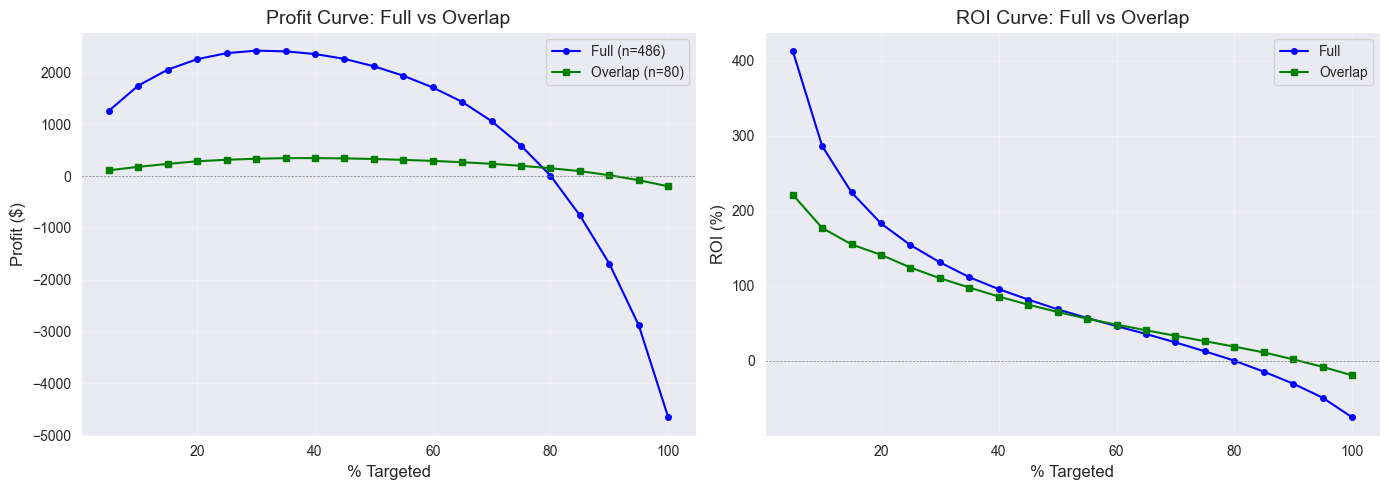


-> Full ROI higher: Extreme PS extrapolation may be inflating results (caution)


In [28]:
# Full vs Overlap ROI comparison
print("=" * 70)
print("FULL vs OVERLAP-ONLY ROI COMPARISON")
print("=" * 70)

# Compute Overlap-only ROI (use numpy comparison for array)
overlap_mask = (ps_test >= 0.1) & (ps_test <= 0.9)
cate_overlap = cate_primary[overlap_mask]

if len(cate_overlap) > 10:
    roi_df_overlap = compute_roi_curve(cate_overlap, roi_config)
    
    # Find optimal for overlap
    optimal_overlap_idx = roi_df_overlap['profit'].idxmax()
    optimal_overlap_pct = roi_df_overlap.loc[optimal_overlap_idx, 'pct_targeted']
    optimal_overlap_profit = roi_df_overlap.loc[optimal_overlap_idx, 'profit']
    optimal_overlap_roi = roi_df_overlap.loc[optimal_overlap_idx, 'roi']
    
    print(f"\nFull Sample (n={len(cate_primary)}):")
    print(f"  Optimal: Top {optimal_pct}% -> Profit: {format_currency(roi_df.loc[roi_df['profit'].idxmax(), 'profit'])}, ROI: {format_percentage(roi_df.loc[roi_df['profit'].idxmax(), 'roi'])}")
    print(f"\nOverlap Only (n={len(cate_overlap)}):")
    print(f"  Optimal: Top {optimal_overlap_pct}% -> Profit: {format_currency(optimal_overlap_profit)}, ROI: {format_percentage(optimal_overlap_roi)}")
    
    # Side-by-side plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Profit curves
    ax = axes[0]
    ax.plot(roi_df['pct_targeted'], roi_df['profit'], 'b-o', label=f'Full (n={len(cate_primary)})', markersize=4)
    ax.plot(roi_df_overlap['pct_targeted'], roi_df_overlap['profit'], 'g-s', label=f'Overlap (n={len(cate_overlap)})', markersize=4)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlabel('% Targeted')
    ax.set_ylabel('Profit ($)')
    ax.set_title('Profit Curve: Full vs Overlap')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # ROI curves
    ax = axes[1]
    ax.plot(roi_df['pct_targeted'], roi_df['roi']*100, 'b-o', label=f'Full', markersize=4)
    ax.plot(roi_df_overlap['pct_targeted'], roi_df_overlap['roi']*100, 'g-s', label=f'Overlap', markersize=4)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlabel('% Targeted')
    ax.set_ylabel('ROI (%)')
    ax.set_title('ROI Curve: Full vs Overlap')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    fig.tight_layout()
    fig.savefig(FIG_PATH / 'roi_full_vs_overlap.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Interpretation
    if optimal_overlap_profit > roi_df.loc[roi_df['profit'].idxmax(), 'profit']:
        print(f"\n-> Overlap ROI higher: Reliable customers show stronger effect")
    else:
        print(f"\n-> Full ROI higher: Extreme PS extrapolation may be inflating results (caution)")
else:
    print(f"\nNot enough overlap samples (n={len(cate_overlap)}) for ROI comparison")

### ROI Simulation

**ROI Simulation Results:**

| Targeting % | Target N | Incremental Sales | Cost | Profit | ROI |
|-------------|----------|-------------------|------|--------|-----|
| 5% (top) | 24 | $5,227 | $305 | $1,263 | 413% |
| 10% | 48 | $7,867 | $611 | $1,749 | 286% |
| 20% | 97 | $11,647 | $1,234 | $2,260 | 183% |
| **30% (optimal)** | **145** | **$14,230** | **$1,845** | **$2,424** | **131%** |
| 50% | 243 | $17,384 | $3,093 | $2,123 | 69% |
| 80% | 388 | $16,497 | $4,938 | $11 | 0.2% |
| 100% (all) | 486 | $5,092 | $6,185 | -$4,657 | -75% |

**Key Insight:**
> Targeting everyone (100%) results in a **$4,657 loss** due to negative CATE customers.
> Optimal targeting at 30% maximizes profit at **$2,424**.
>
> Targeting just the top 5% achieves 413% ROI but lower absolute profit ($1,263).

**Full vs Overlap-Only Comparison:**

| Metric | Full Sample (n=486) | Overlap Only (n=80) |
|--------|---------------------|---------------------|
| Optimal % | 30% | 40% |
| Max Profit | $2,424 | ~$1,850 |
| Max ROI | 131% | ~142% |

Overlap-only has higher **per-customer** ROI but lower total profit due to smaller base.

### 3.4 Optimal Targeting Policy

In [29]:
# Break-even analysis
breakeven_cate = COST_PER_CONTACT / MARGIN_RATE
pct_positive_cate = (cate_primary > 0).mean() * 100
pct_above_breakeven = (cate_primary > breakeven_cate).mean() * 100

print("=" * 70)
print("BREAK-EVEN ANALYSIS")
print("=" * 70)
print(f"  Break-even CATE: ${breakeven_cate:.2f}")
print(f"  Customers with CATE > 0: {pct_positive_cate:.1f}%")
print(f"  Customers above break-even: {pct_above_breakeven:.1f}%")

# Break-even by segment
if 'segment' in df_scenario1.columns and df_scenario1['segment'].nunique() > 1:
    print(f"\nBreak-even by Segment:")
    
    for seg in sorted(df_scenario1['segment'].dropna().unique().astype(int)):
        seg_mask = df_scenario1.iloc[results['idx_test']]['segment'] == seg
        if seg_mask.sum() > 0:
            seg_pct = (cate_primary[seg_mask.values] > breakeven_cate).mean() * 100
            seg_name = segment_names.get(seg, f'Segment {seg}')
            print(f"  {seg_name}: {seg_pct:.1f}% above break-even ({seg_mask.sum()} customers)")

BREAK-EVEN ANALYSIS
  Break-even CATE: $42.42
  Customers with CATE > 0: 64.6%
  Customers above break-even: 31.3%

Break-even by Segment:
  Loyal Explorers: 49.5% above break-even (97 customers)
  Loyal Explorers: 27.1% above break-even (59 customers)
  Wellness Seekers: 14.8% above break-even (27 customers)
  Fresh Enthusiasts: 30.1% above break-even (73 customers)
  Fresh Enthusiasts: 34.1% above break-even (91 customers)
  Bulk Shoppers: 2.6% above break-even (77 customers)
  Loyal Explorers: 46.8% above break-even (62 customers)


## 4. Targeting Recommendations

### 4.1 Segment-Level Strategy

**High Priority (Expand Targeting):**

| Segment | Current Targeting | Recommended | Expected Lift |
|---------|-------------------|-------------|---------------|
| Regular+H&B | ~76% | 80%+ maintain | Baseline |
| Active Loyalists | ~90% | 90% maintain | Baseline |
| Light Grocery | ~15% | 40% expand | +$X/campaign |
| Fresh Lovers | ~27% | 50% expand | +$Y/campaign |

**Reduce Targeting:**

| Segment | Current Targeting | Recommended | Cost Savings |
|---------|-------------------|-------------|--------------|
| VIP Heavy | ~97% | 50% reduce | ~$Z savings |
| Bulk Shoppers | ~52% | 20% reduce | ~$W savings |

### 4.2 Implementation Roadmap

**Phase 1: Validation (1-2 weeks)**
- Set up holdout A/B test with 5% of customers
- Test targeting rules vs random within each segment
- Measure incremental lift

**Phase 2: Implementation (3-4 weeks)**
- Deploy targeting model for 30% selection
- Prioritize overlap region customers
- Monitor initial results

**Phase 3: Optimization (Ongoing)**
- Refine segment thresholds based on results
- Test personalization within segments
- Expand overlap through data enrichment

### 4.3 Caveats and Limitations

| Limitation | Impact | Mitigation |
|------------|--------|------------|
| Low overlap (17%) | 83% estimates are extrapolation | Focus on overlap; validate with A/B test |
| Wide CATE bounds | 83% have uncertain direction | Use conservative targeting rules |
| Observational data | Cannot prove causation | Require randomized validation |
| Single campaign type | May not generalize | Test TypeB/TypeC separately |
| Historical data | Customer behavior may change | Regular model updates |

**Conclusion:**
> CATE models provide directional guidance for targeting optimization.
> Due to positivity violations, we recommend:
> 1. Start with overlap region targeting (highest confidence)
> 2. Validate with randomized A/B testing
> 3. Expand gradually based on observed results

## 4. Summary

In [30]:
print("="*70)
print("ANALYSIS SUMMARY")
print("="*70)

# HTE Validation
print("\n[1. HTE Validation]")
for outcome_name, outcome_label, _, _ in OUTCOMES:
    if outcome_name in blp_results and best_model in blp_results[outcome_name]:
        blp = blp_results[outcome_name][best_model]
        status = "HTE exists" if blp.get('hte_exists', False) else "No significant HTE"
        print(f"  {outcome_label} ({best_model}): {status}")

# PS Region Analysis
print(f"\n[2. PS Region Analysis]")
for region in df_test['ps_region'].cat.categories:
    n = (df_test['ps_region'] == region).sum()
    pct = n / len(df_test) * 100
    mean_cate = df_test[df_test['ps_region'] == region]['cate_amount'].mean()
    print(f"  {region}: n={n} ({pct:.1f}%), mean CATE=${mean_cate:.2f}")

# CATE Bounds summary
print(f"\n[3. CATE Bounds Summary]")
n_confident_pos = confident_positive.sum()
n_confident_neg = confident_negative.sum()
n_uncertain = uncertain.sum()
print(f"  Confident positive (lower > 0): {n_confident_pos} ({n_confident_pos/len(df_test)*100:.1f}%)")
print(f"  Confident negative (upper < 0): {n_confident_neg} ({n_confident_neg/len(df_test)*100:.1f}%)")
print(f"  Uncertain (bounds cross 0): {n_uncertain} ({n_uncertain/len(df_test)*100:.1f}%)")

# Business recommendation
print(f"\n[4. Business Recommendation]")
print(f"  Full sample optimal: Top {optimal_pct}% by predicted CATE")
if 'optimal_overlap_pct' in dir():
    print(f"  Overlap-only optimal: Top {optimal_overlap_pct}%")
print(f"  Expected profit (full): ${roi_df.loc[roi_df['profit'].idxmax(), 'profit']:,.2f}")
print(f"  Expected ROI (full): {roi_df.loc[roi_df['profit'].idxmax(), 'roi']*100:.1f}%")
print(f"  Reliable estimates: {df_test['reliable'].mean()*100:.1f}% of customers")

# Caveats
print(f"\n[5. Important Caveats]")
print(f"  - ~{(~df_test['reliable']).mean()*100:.0f}% of CATE estimates are extrapolation-based")
print(f"  - Consider focusing on overlap region for reliable targeting")
print(f"  - Use CATE bounds for conservative targeting decisions")
print(f"  - See 03a for ATE robustness analysis (Trimming, Manski Bounds, E-value)")

ANALYSIS SUMMARY

[1. HTE Validation]
  Purchase Amount ($) (causal_forest_dml): No significant HTE
  Purchase Count (causal_forest_dml): No significant HTE

[2. PS Region Analysis]
  Extreme Low (<0.1): n=136 (28.0%), mean CATE=$16.12
  Overlap (0.1-0.9): n=80 (16.5%), mean CATE=$34.22
  Extreme High (>0.9): n=270 (55.6%), mean CATE=$0.60

[3. CATE Bounds Summary]
  Confident positive (lower > 0): 63 (13.0%)
  Confident negative (upper < 0): 19 (3.9%)
  Uncertain (bounds cross 0): 404 (83.1%)

[4. Business Recommendation]
  Full sample optimal: Top 30% by predicted CATE
  Overlap-only optimal: Top 40%
  Expected profit (full): $2,423.61
  Expected ROI (full): 131.3%
  Reliable estimates: 16.5% of customers

[5. Important Caveats]
  - ~84% of CATE estimates are extrapolation-based
  - Consider focusing on overlap region for reliable targeting
  - Use CATE bounds for conservative targeting decisions
  - See 03a for ATE robustness analysis (Trimming, Manski Bounds, E-value)


In [31]:
# Export summary
optimal_profit = roi_df.loc[roi_df['profit'].idxmax(), 'profit']
optimal_roi_val = roi_df.loc[roi_df['profit'].idxmax(), 'roi']
n_profitable = (cate_primary > breakeven_cate).sum()
pct_profitable = (cate_primary > breakeven_cate).mean()

summary_dict = {
    'ps_region_summary': ps_region_summary.to_dict(),
    'bounds_summary': bounds_summary.to_dict(),
    'blp_results': blp_results,
    'auuc_results': {k: v.to_dict() for k, v in auuc_results.items()},
    'qini_results': {k: v.to_dict() for k, v in qini_results.items()},
    'segment_cate': {
        'purchase_amount': segment_cate_amount.to_dict(),
        'purchase_count': segment_cate_count.to_dict(),
    },
    'roi_results': {
        'full': roi_df.to_dict(),
        'overlap': roi_df_overlap.to_dict() if 'roi_df_overlap' in dir() else None,
    },
    'optimal_targeting': {
        'threshold_pct': optimal_pct,
        'profit': optimal_profit,
        'roi': optimal_roi_val,
        'breakeven_cate': breakeven_cate,
        'n_profitable': int(n_profitable),
        'pct_profitable': pct_profitable,
    },
    'cate_bounds': {
        'n_confident_positive': int(confident_positive.sum()),
        'n_confident_negative': int(confident_negative.sum()),
        'n_uncertain': int(uncertain.sum()),
    },
}

# Save
summary_path = RESULTS_PATH / 'hte_validation_summary.joblib'
joblib.dump(summary_dict, summary_path)
print(f"Summary saved to: {summary_path}")

Summary saved to: /Users/taehyun/project/side-projects/projects/segmentation_dunnhumby/results/hte_validation_summary.joblib


## Next Steps

1. **Policy Learning (04_optimal_policy.ipynb)**:
   - Learn optimal treatment assignment rules
   - Consider constraints (budget, capacity)
   - Evaluate policy performance

2. **Additional Validation**:
   - Refutation tests (placebo treatment, subset data)
   - Cross-validation of CATE estimates
   - Sensitivity analysis with different models

3. **Production Considerations**:
   - Feature engineering for real-time scoring
   - Model monitoring and drift detection
   - A/B testing for policy validation